In [191]:
import pickle, gzip, math, numpy as np
import torch, torch.nn as nn, torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from tqdm import tqdm_notebook as tqdm # a package for making progress bar

# $\color{Orange}{\text{Load Data}}$

In [50]:
def loadData(src):
    '''
    return: train_x - 2D Numpy array (n, d) where each row is an image
            train_y - 1D Numpy array (n, ) where each row is a label
            test_x  - 2D Numpy array (n, d) where each row is an image
            test_y  - 1D Numpy array (n, ) where each row is a label
    '''
    f = gzip.open(src, 'rb')
    train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    
    f.close()
    train_x, train_y = train_set
    valid_x, valid_y = valid_set
    test_x, test_y = test_set
    print('Originally, train len (n): '+str(len(train_y))+'  '+'valid len (n): '+str(len(valid_y))+'  '+'test len (n): '+str(len(test_y)))
    train_x = np.vstack((train_x, valid_x))
    train_y = np.append(train_y, valid_y)
    print('Now, train len (n): '+str(len(train_y))+'  '+'test len (n): '+str(len(test_y)))
    print('Each vec len (p): '+str(train_x.shape[1]))
    return (train_x, train_y, test_x, test_y)

In [5]:
def plotImg(X,n=0,p=0):
    '''
    return: image(s) with n rows & p cols
    '''
    num_images = X.shape[0]
    if n == 0 & p == 0:
        num_rows = math.floor(math.sqrt(num_images)) # floor: 2.5 -> 2
        num_cols = math.ceil(num_images/num_rows) # ceil: 2.5 -> 3
    else:
        if n*p < num_images:
            return print("Wrong n, p values")
        num_rows, num_cols = n, p
    plt.figure(figsize=(20,10))
    for i in range(num_images):
        reshaped_image = X[i,:].reshape(28,28)
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(reshaped_image, cmap = cm.Greys_r)
        plt.axis('off')
    plt.show()

# $\color{Orange}{\text{Preprocess Data}}$

In [52]:
# Split into train and dev
split_index = int(9 * len(X_train) / 10)

X_train, y_train = X_train[:split_index], y_train[:split_index]  # 9/10 train set -> n = 54000
X_dev, y_dev= X_train[split_index:], y_train[split_index:]       # 1/10 dev set -> n = 6000

permutation = np.array([i for i in range(len(X_train))])         # an array of nums from 0 to 54000
np.random.shuffle(permutation)                                   # shuffle so as to reorder the data points
X_train = [X_train[i] for i in permutation]
y_train = [y_train[i] for i in permutation]

In [8]:
def batchifyData(X, y, batch_size):
    """
    Takes a set of data points and labels and groups them into batches.
    
    paras: X - inputs; 
           y - outputs; 
           batch_size - how many data points in each batch
    
    return: a list of dict 
            [{'x': tensor(mat1,...,matn), 'y': tensor(num1,...,numn)}, ...]
    """
    # Only take batch_size chunks. The remainder will be dropped.
    N = int(len(X) / batch_size) * batch_size # how many batches we have
    batches = []
    for i in range(0, N, batch_size):
        batches.append({
            'x': torch.tensor(X[i:i+batch_size], dtype=torch.float32),
            'y': torch.tensor(y[i:i+batch_size], dtype=torch.long
        )})
    return batches

In [10]:
# How a batch looks like
train_batches[0]

{'x': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 'y': tensor([2, 1, 1, 4, 4, 4, 9, 1, 0, 1, 1, 9, 3, 9, 0, 1, 3, 1, 3, 2, 8, 4, 9, 9,
         8, 7, 1, 6, 3, 0, 3, 9])}

# $\color{Orange}{\text{Modeling}}$

In [154]:
def train_model(train_data, dev_data, model, lr=0.01, momentum=0.9, nesterov=False, n_epochs=30):
    """
    Train a model for N epochs given data and hyper-params.
    
    return: a list of dictionary with [{'Train Loss','Validation Loss'},{'Train Accuracy','Validation Accuracy'}]
    """
    # We optimize with SGD
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=momentum, nesterov=nesterov)
    train_losses, train_accuracies, val_losses, val_accuracies = [],[],[],[]
    
    for epoch in tqdm.tqdm(range(1, n_epochs+1)):
        print("-------------\nEpoch {}:\n".format(epoch))

        # Run **training***
        train_loss, train_acc = run_epoch(train_data, model.train(), optimizer)
        print('Train loss: {:.6f} | Train accuracy: {:.6f}'.format(loss, acc))
        # Run **validation**
        val_loss, val_acc = run_epoch(dev_data, model.eval(), optimizer)
        print('Val loss:   {:.6f} | Val accuracy:   {:.6f}'.format(val_loss, val_acc))
        
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)
        
        # Save model
        torch.save(model, 'mnist_model_fully_connected.pt')
        
    return [{'Train loss':train_losses,'Validation loss':val_losses},
            {'Train accuracy':train_accuracies,'Validation accuracy':val_accuracies}]

def run_epoch(data, model, optimizer):
    """Train model for one pass of train data, and return loss, acccuracy"""
    # Gather losses
    losses = []
    batch_accuracies = []

    # If model is in train mode, use optimizer.
    is_training = model.training

    # Iterate through batches
    for batch in data:
        # Grab x and y
        x, y = batch['x'], batch['y']

        # Get output predictions
        out = model(x)

        # Predict and store accuracy
        predictions = torch.argmax(out, dim=1)
        ## need to change pytorch tensor to numpy array so as to apply np funcs
        accuracy = np.mean(np.equal(predictions.numpy(), y.numpy()))
        batch_accuracies.append(accuracy)

        # Compute loss
        loss = F.cross_entropy(out, y)
        losses.append(loss.data.item())

        # If training, do an update.
        if is_training:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Calculate epoch level scores
    avg_loss = np.mean(losses)
    avg_accuracy = np.mean(batch_accuracies)
    return avg_loss, avg_accuracy

In [179]:
class Flatten(nn.Module):
    """A custom layer that views an input as 1D."""
    def forward(self, input):
        return input.view(input.size(0), -1)

# $\color{Orange}{\text{Utilities}}$

In [182]:
def processData(algo):
    '''
    return: a list of dictionary with [{'Train Loss','Validation Loss'},{'Train Accuracy','Validation Accuracy'}]
    '''
    if algo == 'FFNN':  # each image is a flattened vector
        X_train_dev_ = X_train_dev
        X_test_ = X_test
    elif algo == 'CNN':  # need to rehape the data back into a 1x28x28 image
        X_train_dev_ = np.reshape(X_train_dev, (X_train_dev.shape[0], 1, 28, 28))
        X_test_ = np.reshape(X_test, (X_test.shape[0], 1, 28, 28))
    
    # Split into train and dev
    split_index = int(9 * len(X_train_dev) / 10)

    X_train, y_train = X_train_dev[:split_index], y_train_dev[:split_index]  # 9/10 train set -> n = 54000
    X_dev, y_dev= X_train_dev[split_index:], y_train_dev[split_index:]       # 1/10 dev set -> n = 6000

    permutation = np.array([i for i in range(len(X_train))])         # an array of nums from 0 to 54000
    np.random.shuffle(permutation)                                   # shuffle so as to reorder the data points
    X_train = [X_train[i] for i in permutation]
    y_train = [y_train[i] for i in permutation]
    
    # Split dataset into batches
    train_batches = batchifyData(X_train, y_train, batch_size)
    dev_batches = batchifyData(X_dev, y_dev, batch_size)
    test_batches = batchifyData(X_test, y_test, batch_size)
    
    # train model
    res = train_model(train_batches, dev_batches, model, lr=lr, momentum=momentum, nesterov=nesterov, n_epochs=n_epochs)
    
    # Evaluate the model on test data
    loss, accuracy = run_epoch(test_batches, model.eval(), None)
    print()
    print("Loss on test set:"  + str(loss) + " Accuracy on test set: " + str(accuracy))
    return res

In [165]:
def plotRes(res_dict,title):
    for key, values in res_dict.items():
        plt.plot(values, marker='o', markersize=5, label=key)
    plt.legend()
    plt.title(title)

# $\color{Orange}{\text{Set Parameters & Run Model}}$

In [183]:
np.random.seed(12321)  # for reproducibility
torch.manual_seed(12321)  # for reproducibility
X_train_dev, y_train_dev, X_test, y_test = loadData('mnist.pkl.gz')

Originally, train len (n): 50000  valid len (n): 10000  test len (n): 10000
Now, train len (n): 60000  test len (n): 10000
Each vec len (p): 784


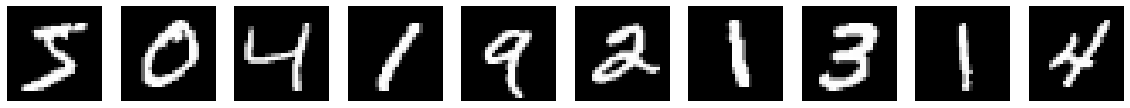

In [158]:
plotImg(X_train_dev[:10],1,10)

In [184]:
# Model specification
batch_size = 64

## Hidden Layer Representation Size
unit_size = 128

## FFNN Model
model_ffnn = nn.Sequential(
    nn.Linear(784, unit_size),
    nn.LeakyReLU(),
    nn.Linear(unit_size, 10)
)

## CNN Model
model_cnn = nn.Sequential(
    nn.Conv2d(1, 32, (3, 3)),
    nn.ReLU(),
    nn.MaxPool2d((2, 2)),
    nn.Conv2d(32, 64, (3,3)),
    nn.ReLU(),
    nn.MaxPool2d((2,2)),
    Flatten(),
    nn.Linear(1600,unit_size),
    nn.Dropout(),
    nn.Linear(unit_size,10)
)
        
lr = 0.1
momentum = 0.9
nesterov = False
n_epochs = 20

In [185]:
# test accuracy = 0.9204727564102564 when batch size = 64 lr = 0.1
res = processData('CNN')


  0%|          | 0/10 [00:00<?, ?it/s]

-------------
Epoch 1:




 10%|█         | 1/10 [00:02<00:22,  2.46s/it]

Train loss: 0.204818 | Train accuracy: 0.940983
Val loss:   0.127970 | Val accuracy:   0.966230
-------------
Epoch 2:




 20%|██        | 2/10 [00:04<00:18,  2.34s/it]

Train loss: 0.204818 | Train accuracy: 0.940983
Val loss:   0.134007 | Val accuracy:   0.968918
-------------
Epoch 3:




 30%|███       | 3/10 [00:06<00:15,  2.24s/it]

Train loss: 0.204818 | Train accuracy: 0.940983
Val loss:   0.111214 | Val accuracy:   0.973454
-------------
Epoch 4:




 40%|████      | 4/10 [00:08<00:12,  2.17s/it]

Train loss: 0.204818 | Train accuracy: 0.940983
Val loss:   0.117545 | Val accuracy:   0.973622
-------------
Epoch 5:




 50%|█████     | 5/10 [00:10<00:10,  2.12s/it]

Train loss: 0.204818 | Train accuracy: 0.940983
Val loss:   0.128817 | Val accuracy:   0.971606
-------------
Epoch 6:




 60%|██████    | 6/10 [00:12<00:08,  2.10s/it]

Train loss: 0.204818 | Train accuracy: 0.940983
Val loss:   0.110177 | Val accuracy:   0.975806
-------------
Epoch 7:




 70%|███████   | 7/10 [00:14<00:06,  2.07s/it]

Train loss: 0.204818 | Train accuracy: 0.940983
Val loss:   0.110957 | Val accuracy:   0.976647
-------------
Epoch 8:




 80%|████████  | 8/10 [00:16<00:03,  1.99s/it]

Train loss: 0.204818 | Train accuracy: 0.940983
Val loss:   0.149728 | Val accuracy:   0.971102
-------------
Epoch 9:




 90%|█████████ | 9/10 [00:18<00:02,  2.01s/it]

Train loss: 0.204818 | Train accuracy: 0.940983
Val loss:   0.122145 | Val accuracy:   0.977991
-------------
Epoch 10:




100%|██████████| 10/10 [00:20<00:00,  2.01s/it]

Train loss: 0.204818 | Train accuracy: 0.940983
Val loss:   0.145686 | Val accuracy:   0.975302

Loss on test set:0.13679060793648928 Accuracy on test set: 0.9731570512820513


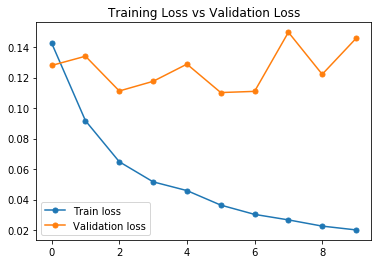

In [186]:
plotRes(res[0],'Training Loss vs Validation Loss')

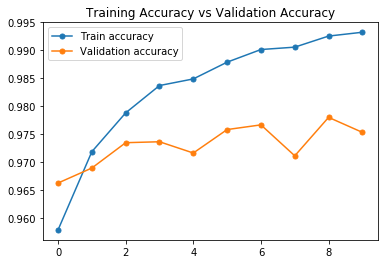

In [187]:
plotRes(res[1],'Training Accuracy vs Validation Accuracy') # CNN

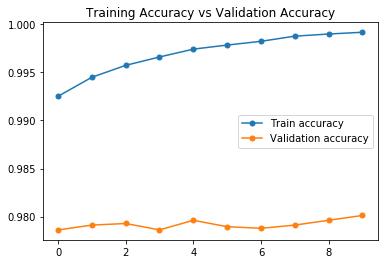

In [176]:
plotRes(res[1],'Training Accuracy vs Validation Accuracy') # FFNN

In [ ]:
# Grab x and y
x, y = batch['x'], batch['y']

# Get output predictions
out = model(x)

# Predict and store accuracy
predictions = torch.argmax(out, dim=1)
## need to change pytorch tensor to numpy array so as to apply np funcs
accuracy = np.mean(np.equal(predictions.numpy(), y.numpy()))
batch_accuracies.append(accuracy)

In [217]:
pred = torch.argmax(model(test_batches[0]['x']),dim=1)

In [220]:
np.mean(np.equal(pred.numpy(),test_batches[0]['y'].numpy()))

1.0